In [ ]:
# Este es el modelo de regresión 1 para la Estrategia 1. Trabajaremos con el 80% del dataset.   

In [95]:
# Paso 1: Importar las bibliotecas necesarias

import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler


In [96]:
# Paso 2: Carga de datos 

df = pd.read_csv("../data/feature_engineering.csv")



In [97]:
# Transformación logarítmica

# Aplica la transformación logarítmica
cols_to_transform = ['price']
df[cols_to_transform] = df[cols_to_transform].apply(np.log1p)

In [98]:
df

,year,kms,power,price,make_Abarth,make_Alfa Romeo,make_Alpine,make_Aston Martin,make_Audi,make_BMW,...,segmento_A,segmento_B,segmento_C,segmento_D,segmento_E,segmento_F,segmento_J,segmento_M,segmento_S,segmento_otros
0,2017,93000.0,110.0,9.609184,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
1,2019,151716.0,131.0,9.947552,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,2018,84490.0,85.0,9.278092,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
3,2018,172844.0,286.0,10.971658,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
4,2015,69000.0,130.0,9.532424,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8943,2013,137186.0,211.0,10.714440,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
8944,2014,137000.0,258.0,10.400954,False,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
8945,2016,29445.0,90.0,9.903037,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
8946,2003,111980.0,395.0,9.615205,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [99]:
# Separar características (X) y variable objetivo (y)
X = df.drop(columns="price")
y_log = df["price"]

In [100]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

In [101]:
# scaler = StandardScaler()
# X_train_log_scaled = scaler.fit_transform(X_train_log)
# X_test_log_scaled = scaler.transform(X_test_log)

XGBRegressor

In [102]:
# Definir modelo base
xgb_model = XGBRegressor(random_state=42)

# Hiperparámetros para GridSearch
param_grid = {
    "max_depth": [4, 5, 6],
    "n_estimators": [50,100,150],
    "learning_rate": [0.05,0.1,0.2]
}

# Grid search con validación cruzada
xgb_grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)

# Entrenar modelo
xgb_grid_search.fit(X_train, y_train_log)

# Mejor modelo encontrado
best_xgb = xgb_grid_search.best_estimator_

# Predicciones
y_train_log_pred = best_xgb.predict(X_train)
y_test_log_pred = best_xgb.predict(X_test)


# Revertir la transformación logarítmica para evaluar en la escala original

y_train_pred = np.expm1(y_train_log_pred)
y_test_pred = np.expm1(y_test_log_pred)
y_train = np.expm1(y_train_log)
y_test = np.expm1(y_test_log)

# Métricas de evaluación en la escala original
mae_train_xgb = mean_absolute_error(y_train, y_train_pred)
mae_test_xgb = mean_absolute_error(y_test, y_test_pred)

# R² (en la escala original)
r2_train_xgb = r2_score(y_train, y_train_pred)
r2_test_xgb = r2_score(y_test, y_test_pred)

# Resultados
print("=== Evaluación del mejor modelo XGBoost ===")
print(f"Mejores hiperparámetros: {xgb_grid_search.best_params_}")
print(f"MAE en entrenamiento: {mae_train_xgb:.4f}")
print(f"MAE en prueba:        {mae_test_xgb:.4f}")
print(f"R² en entrenamiento: {r2_train_xgb:.4f}")
print(f"R² en prueba:        {r2_test_xgb:.4f}")

=== Evaluación del mejor modelo XGBoost ===
Mejores hiperparámetros: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 150}
MAE en entrenamiento: 1973.0419
MAE en prueba:        2861.5847
R² en entrenamiento: 0.9778
R² en prueba:        0.9165


Random Forest

In [103]:

# Definir el modelo base
rf_model = RandomForestRegressor(random_state=42)

# Espacio de búsqueda de hiperparámetros
param_grid = {
    "n_estimators": [50,100, 150],
    "max_depth": [10,12,13],
    # Puedes añadir más parámetros si los deseas:
    # "max_features": [8, 9, 10],
    # "max_leaf_nodes": [70, 100, 140]
}

# Configurar búsqueda en cuadrícula con validación cruzada
grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)

# Entrenar el modelo con el conjunto de entrenamiento
grid_search_rf.fit(X_train, y_train_log)

# Mejor modelo encontrado
best_rf = grid_search_rf.best_estimator_

# Predicciones
y_train_log_pred = best_rf.predict(X_train)
y_test_log_pred = best_rf.predict(X_test)

# Revertir la transformación logarítmica para evaluar en la escala original

y_train_pred = np.expm1(y_train_log_pred)
y_test_pred = np.expm1(y_test_log_pred)
y_train = np.expm1(y_train_log)
y_test = np.expm1(y_test_log)


# Evaluación con MAE
mae_train_rf = mean_absolute_error(y_train, y_train_pred)
mae_test_rf = mean_absolute_error(y_test, y_test_pred)

# R² (en la escala original)
r2_train_rf = r2_score(y_train, y_train_pred)
r2_test_rf = r2_score(y_test, y_test_pred)

# Resultados
print("=== Evaluación del mejor modelo Random Forest ===")
print(f"Mejores hiperparámetros: {grid_search_rf.best_params_}")
print(f"MAE en entrenamiento: {mae_train_rf:.4f}")
print(f"MAE en prueba:        {mae_test_rf:.4f}")
print(f"R² en entrenamiento: {r2_train_rf:.4f}")
print(f"R² en prueba:        {r2_test_rf:.4f}")

=== Evaluación del mejor modelo Random Forest ===
Mejores hiperparámetros: {'max_depth': 13, 'n_estimators': 150}
MAE en entrenamiento: 1891.7858
MAE en prueba:        2903.7556
R² en entrenamiento: 0.9703
R² en prueba:        0.9149


=== Evaluación del mejor modelo CatBoost ===
Mejores hiperparámetros: {'depth': 8, 'iterations': 300, 'learning_rate': 0.2}
MAE en entrenamiento: 2067.7982
MAE en prueba:        2746.7398
R² en entrenamiento: 0.9736
R² en prueba:        0.9153


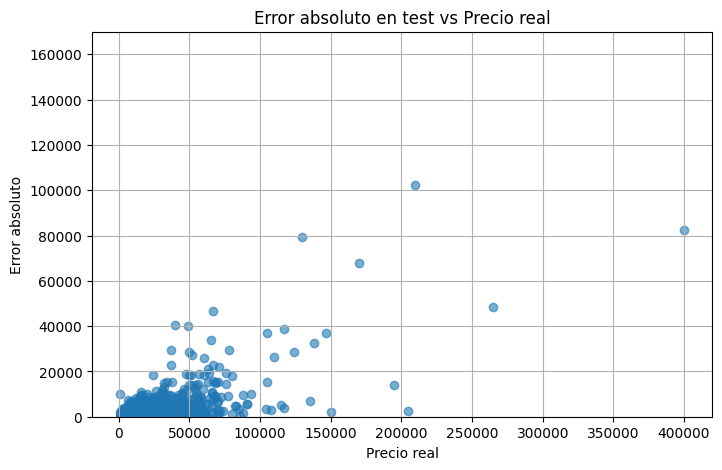

In [110]:
# Definir el modelo base
cat_model = CatBoostRegressor(random_state=42, verbose=0)

# Espacio de búsqueda de hiperparámetros
param_grid = {
    "depth": [4, 6, 8],
    "learning_rate": [0.05, 0.1, 0.2],
    "iterations": [200, 300]
}

# Configurar búsqueda en cuadrícula con validación cruzada
grid_search_cat = GridSearchCV(
    estimator=cat_model,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)

# Entrenar el modelo con el conjunto de entrenamiento
grid_search_cat.fit(X_train, y_train_log)

# Mejor modelo encontrado
best_cat = grid_search_cat.best_estimator_

# Predicciones
y_train_log_pred = best_cat.predict(X_train)
y_test_log_pred = best_cat.predict(X_test)

# Revertir la transformación logarítmica para evaluar en la escala original

y_train_pred = np.expm1(y_train_log_pred)
y_test_pred = np.expm1(y_test_log_pred)
y_train = np.expm1(y_train_log)
y_test = np.expm1(y_test_log)

# Evaluación con MAE
mae_train_cat = mean_absolute_error(y_train, y_train_pred)
mae_test_cat = mean_absolute_error(y_test, y_test_pred)

# Evaluación con R²
r2_train_cat = r2_score(y_train, y_train_pred)
r2_test_cat = r2_score(y_test, y_test_pred)

# Resultados
print("=== Evaluación del mejor modelo CatBoost ===")
print(f"Mejores hiperparámetros: {grid_search_cat.best_params_}")
print(f"MAE en entrenamiento: {mae_train_cat:.4f}")
print(f"MAE en prueba:        {mae_test_cat:.4f}")
print(f"R² en entrenamiento: {r2_train_cat:.4f}")
print(f"R² en prueba:        {r2_test_cat:.4f}")


import matplotlib.pyplot as plt
import numpy as np

# Error absoluto por muestra
errors_abs = np.abs(y_test - y_test_pred)

plt.figure(figsize=(8,5))
plt.scatter(y_test, errors_abs, alpha=0.6)
plt.xlabel('Precio real')
plt.ylabel('Error absoluto')
plt.title('Error absoluto en test vs Precio real')
plt.ylim(0, 170000)  # Limitar eje Y
plt.grid(True)
plt.show()

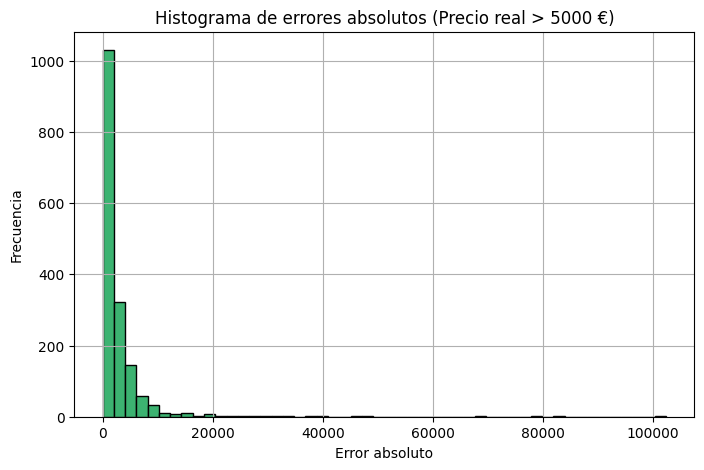

In [113]:
# Calcular residuos absolutos
errores_abs = np.abs(y_test - y_test_pred)

# Filtrar solo los valores con precio real > 5000
mask_mayores_5000 = y_test > 5000
errores_filtrados = errores_abs[mask_mayores_5000]

# Histograma
plt.figure(figsize=(8, 5))
plt.hist(errores_filtrados, bins=50, color='mediumseagreen', edgecolor='black')
plt.title('Histograma de errores absolutos (Precio real > 5000 €)')
plt.xlabel('Error absoluto')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

In [107]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

# Definir el modelo base
gb_model = GradientBoostingRegressor(random_state=42)

# Espacio de búsqueda de hiperparámetros
param_grid = {
    "n_estimators": [50, 70, 100],
    "max_depth": [3, 5, 6],
    "learning_rate": [0.05, 0.1, 0.2]
}

# Configurar búsqueda en cuadrícula con validación cruzada
grid_search_gb = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)

# Entrenar el modelo con el conjunto de entrenamiento
grid_search_gb.fit(X_train, y_train_log)

# Mejor modelo encontrado
best_gb = grid_search_gb.best_estimator_

# Predicciones
y_train_log_pred = best_gb.predict(X_train)
y_test_log_pred = best_gb.predict(X_test)

# Revertir la transformación logarítmica para evaluar en la escala original

y_train_pred = np.expm1(y_train_log_pred)
y_test_pred = np.expm1(y_test_log_pred)
y_train = np.expm1(y_train_log)
y_test = np.expm1(y_test_log)

# Evaluación con MAE
mae_train_gb = mean_absolute_error(y_train, y_train_pred)
mae_test_gb = mean_absolute_error(y_test, y_test_pred)

# Evaluación con R²
r2_train_gb = r2_score(y_train, y_train_pred)
r2_test_gb = r2_score(y_test, y_test_pred)

# Resultados
print("=== Evaluación del mejor modelo Gradient Boosting ===")
print(f"Mejores hiperparámetros: {grid_search_gb.best_params_}")
print(f"MAE en entrenamiento: {mae_train_gb:.4f}")
print(f"MAE en prueba:        {mae_test_gb:.4f}")
print(f"R² en entrenamiento: {r2_train_gb:.4f}")
print(f"R² en prueba:        {r2_test_gb:.4f}")

=== Evaluación del mejor modelo Gradient Boosting ===
Mejores hiperparámetros: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 100}
MAE en entrenamiento: 2085.7481
MAE en prueba:        2979.0342
R² en entrenamiento: 0.9782
R² en prueba:        0.8892


In [108]:
# Crear tabla con los resultados
resultados_modelos = pd.DataFrame({
    "Modelo": ["Random Forest", "XGBoost", "CatBoost", "Gradient Boosting"],
    "MAE Train": [mae_train_rf, mae_train_xgb, mae_train_cat, mae_train_gb],
    "MAE Test": [mae_test_rf, mae_test_xgb, mae_test_cat, mae_test_gb],
    "R² Train": [r2_train_rf, r2_train_xgb, r2_train_cat, r2_train_gb],
    "R² Test": [r2_test_rf, r2_test_xgb, r2_test_cat, r2_test_gb]
})

# Mostrar tabla ordenada por mejor MAE en test
resultados_modelos = resultados_modelos.sort_values(by="MAE Test", ascending=True)

# Visualizar
print(resultados_modelos)

              Modelo    MAE Train     MAE Test  R² Train   R² Test
2           CatBoost  2067.798235  2746.739818  0.973616  0.915342
1            XGBoost  1973.041923  2861.584726  0.977840  0.916465
0      Random Forest  1891.785826  2903.755647  0.970343  0.914907
3  Gradient Boosting  2085.748097  2979.034159  0.978226  0.889179


In [109]:
# Vamos a guardar un modelo

from joblib import dump

# Guardamos el mejor modelo. En este caso Modelo CatBoost. Se ha trabajado con transformada logarítmica en target precio
dump(best_cat, "../model/Modelo1_regresion_cat_logY.pkl")
print("✅ Modelo de CatBoost con transformación logaritmica en target 'Modelo1_regresion_cat_logY.pkl'")


✅ Modelo de CatBoost con transformación logaritmica en target 'Modelo1_regresion_cat_logY.pkl'
